In [14]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import tabulate

from os.path import join
from comm_data import preprocess

import sys
sys.path.append("..")
from seal.trainer.communication import *

RESULTS_DIR = "smartcomp-results"
HUE_ORDER = ["Federated", "Centralized", "Decentralized"]
STYLE_ORDER = ["Federated", "Centralized", "Decentralized"]
plt.style.use(["science", "ieee", "no-latex"])
warnings.simplefilter("ignore")

# Loading Training Data

In [15]:
base_path = ("..", "out", "data")
dfs = []
for intersection in ["grid-3x3", "grid-5x5", "grid-7x7"]:
    for ranked in [False]:
        ranked_str = "ranked" if ranked else "unranked"
        paths = [join(*base_path, "MARL",  intersection, f"v4_{ranked_str}.csv"),
                 join(*base_path, "SARL",  intersection, f"v4_{ranked_str}.csv"),
                 join(*base_path, "FedRL", intersection, f"v4_naive-aggr_{ranked_str}.csv")]
        dfs.extend([preprocess(path, intersection=intersection)
                    for path in paths])

df = pd.concat(dfs)
df.reset_index(inplace=True)
df.replace({"grid-3x3": "Grid-3x3", "grid-5x5": "Grid-5x5", "grid-7x7": "Grid-7x7"}, inplace=True)
INTERSECTIONS = df["intersection"].unique().tolist()
df.head()

index  tls-to-edge-policy-comms  veh-to-tls-info-comms  \
0      0                         0                    846   
1      1                         0                    977   
2      2                         0                   1029   
3      3                         0                    972   
4      4                         0                   1171   

   tls-to-edge-obs-comms  edge-to-tls-policy-comms  edge-to-tls-rank-comms  \
0                      0                         0                       0   
1                      0                         0                       0   
2                      0                         0                       0   
3                      0                         0                       0   
4                      0                         0                       0   

   edge-to-tls-action-comms        trainer  iteration  round intersection  \
0                         0  Decentralized          1      0     Grid-3x3   
1                         0  Decentralized          1      0     Grid-3x3   
2                         0  Decentralized          1      0     Grid-3x3   
3                         0  Decentralized          1      0     Grid-3x3   
4                         0  Decentralized          1      0     Grid-3x3   

   timesteps_total  ranked weight_aggr_fn  episode_reward_mean  episode  \
0             4000   False            N/A            -9.836773        0   
1             4000   False            N/A            -9.836773        0   
2             4000   False            N/A            -9.836773        0   
3             4000   False            N/A            -9.836773        0   
4             4000   False            N/A            -9.836773        0   

   total_comm_cost tls  
0              846  A1  
1              977  A0  
2             1029  A2  
3              972  B1  
4             1171  C0

# Reward Results

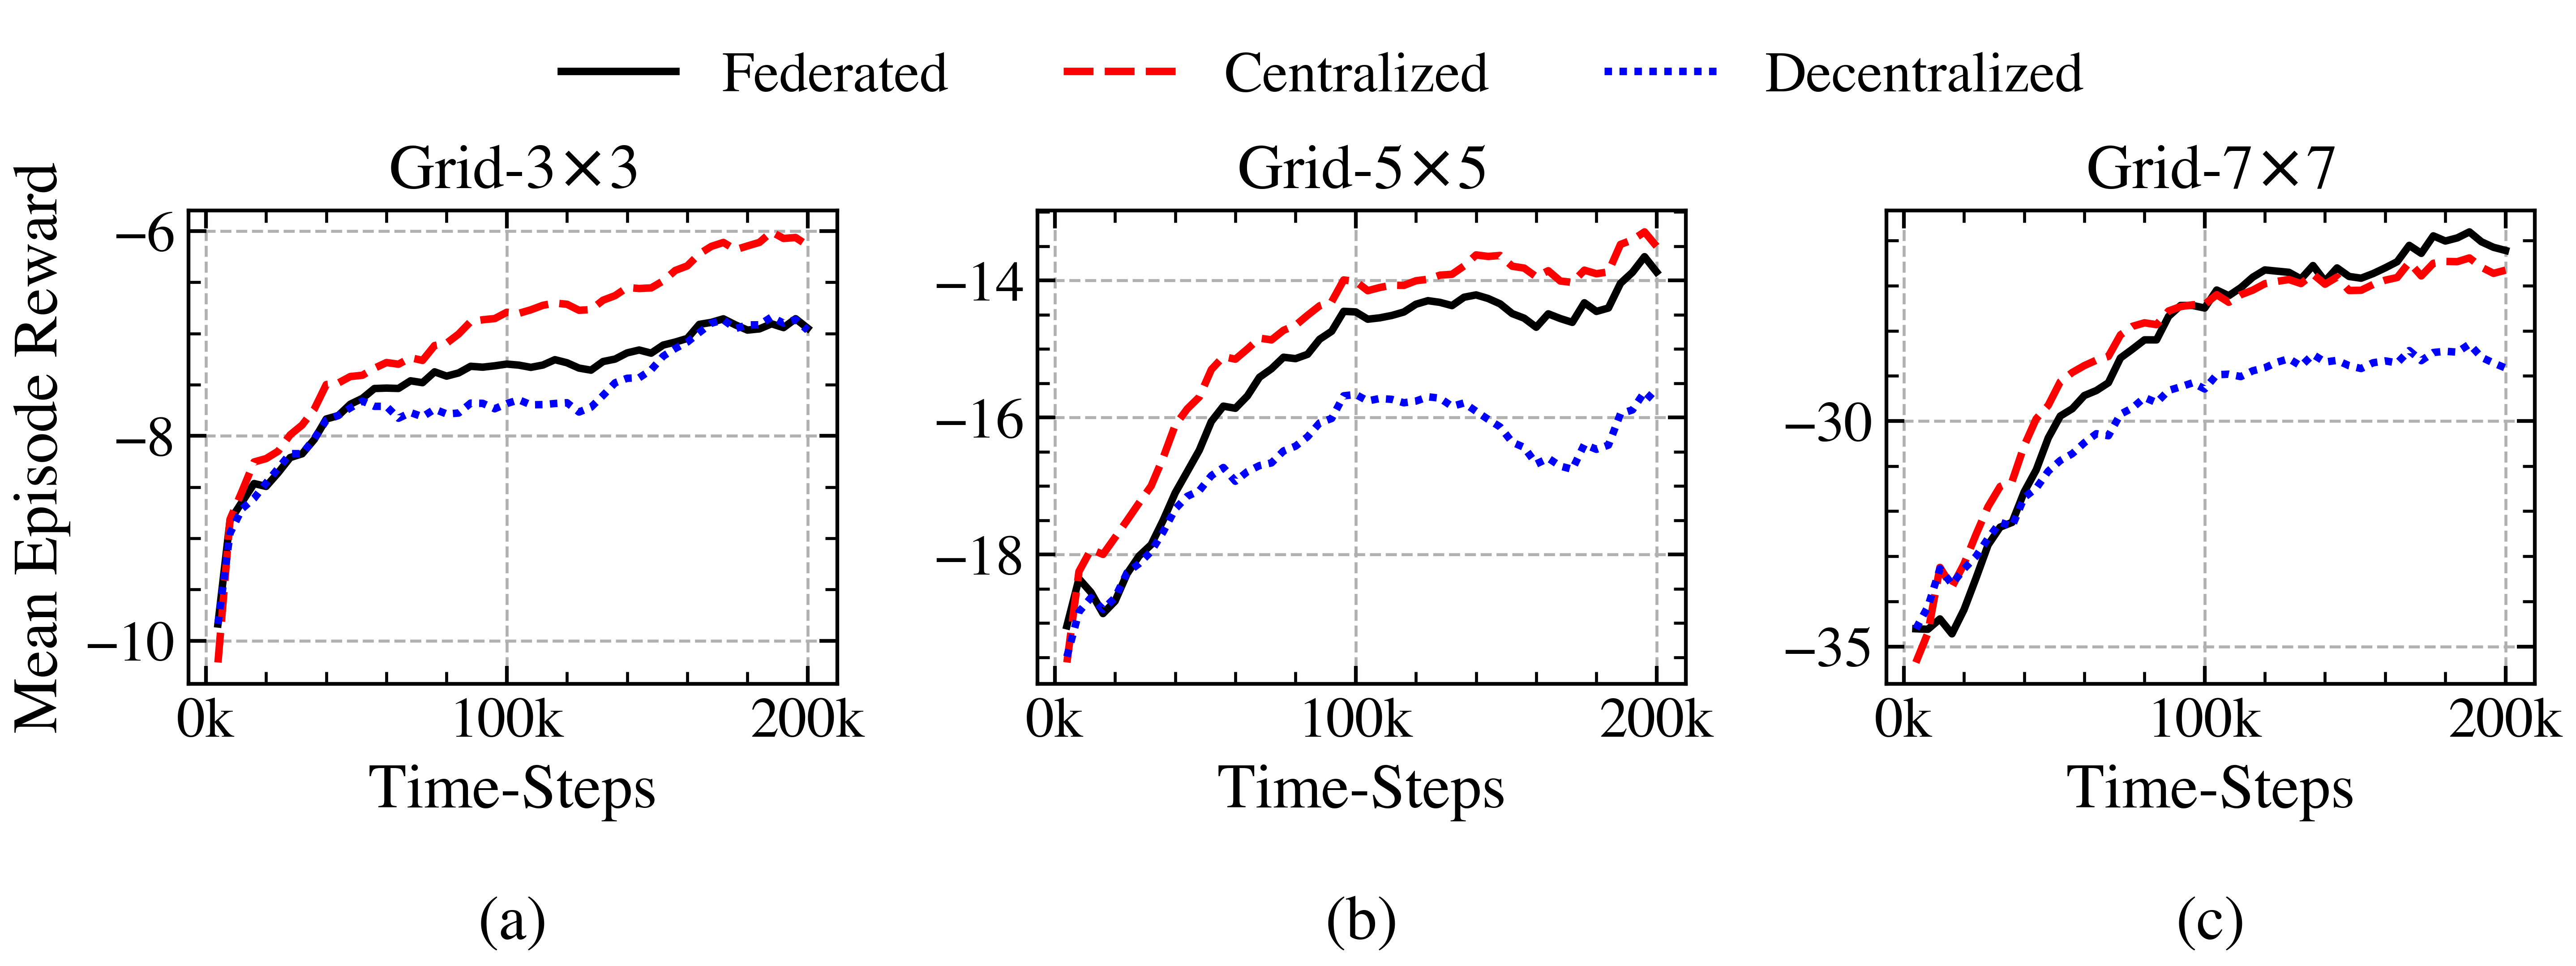

In [16]:
with sns.plotting_context("paper", font_scale=1.75):
    fig, axes = plt.subplots(ncols=len(INTERSECTIONS), figsize=(10, 4))
    for (i, intersection) in enumerate(INTERSECTIONS):
        query = f"intersection == '{intersection}'"
        sns.lineplot(
            data=df.query(query),
            x="timesteps_total",
            y="episode_reward_mean",
            hue="trainer",
            hue_order=HUE_ORDER,
            style="trainer",
            style_order=STYLE_ORDER,
            ci=None,
            ax=axes[i],
            linewidth=2
        )
        axes[i].grid(which="major", linestyle="--")
        axes[i].set_xlabel("Time-Steps")
        axes[i].set_ylabel("Mean Episode Reward")
        axes[i].set_xticklabels(["", "0k", "100k", "200k"])
        handles, labels = axes[i].get_legend_handles_labels()
        axes[i].get_legend().remove()
        title = f"\n\n{intersection}".title().replace("X", "$\\times$")
        axes[i].set_title(title)

    for i in range(1, len(INTERSECTIONS)):
        axes[i].set_ylabel("")

    for label, i in zip(["a", "b", "c"], range(len(INTERSECTIONS))):
        axes[i].set_xlabel(f"Time-Steps\n\n({label})")

    handles = [copy.copy(ha) for ha in handles]
    [ha.set_linewidth(2) for ha in handles]
    fig.legend(handles, labels, frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.5125, 0.95))
    plt.tight_layout()
    plt.savefig(join(RESULTS_DIR, "training_reward.pdf"))
    plt.show()

# Communication Cost Results
Here, we perform analysis of the cost associated with each of the training approaches. To do this, our code tracked `6` different kinds of communications:
* `tls-to-edge-policy-comms`
* `edge-to-tls-action-comms`
* `edge-to-tls-rank-comms`
* `edge-to-tls-policy-comms`
* `veh-to-tls-info-comms`
* `tls-to-edge-obs-comms`

During the training, we track the number of occurrences of each of the communication types. This is then so we can do analysis via post-processing where the byte sizes of each data type is applied as weights to get a better sense of the actual communication type.

First, we define a function, `comm_df_fn(.)`, that creates an auxialiary `DataFrame` with a new column, `weighted_comm_cost`. This function takes a dictionary of weights for the `6` communication types (mentioned above) and then applies them to make a weighted sum.

## Note.
It is important to note that this analysis is limited to the fact that the state space representation of our approach is very simple. In a real-world implementation, we may want to include live video feed as a feature of a state space. Such data would be much more costly than a relatively small vector (i.e., $1\times10$) of floats.

The values for the byte size weights can be found in the sibling `Data Transmission Sizes` notebook.

In [17]:
def comm_df_fn(weights: dict=None) -> pd.DataFrame:
    """This helper function takes weights associated with each communication type
       (i.e., the amount of bytes) and the number of hops to the edge (if provided)
       to then compute the total **weighted** communication cost. Providing no dictionary
       of weights will result in an **unweighted** total."""
    weights = dict() if weights is None else weights
    for comm_type in COMM_TYPES:
        if comm_type not in weights:
            weights[comm_type] = 1.0

    def fn(row):
        weighted_total =  sum(row[comm_type] * weights[comm_type]
                              for comm_type in COMM_TYPES)
        weighted_total += sum(row[comm_type] * weights["hops-to-edge"]
                              for comm_type in COMM_TYPES
                              if "edge" in comm_type)
        return weighted_total

    comm_df = df.copy()
    comm_df["weighted_comm_cost"] = df.apply(lambda row: fn(row), axis=1)
    return comm_df

In [18]:
# This block gets the `comm_df` DataFrame for performing the communication analysis.
comm_weights = {"hops-to-edge":               1,
                "edge-to-tls-rank-comms":   112,
                "tls-to-edge-obs-comms":    136,
                "tls-to-edge-policy-comms": 640,
                "edge-to-tls-policy-comms": 640,
                "veh-to-tls-info-comms":    108,
                "edge-to-tls-action-comms":  24}
comm_df = comm_df_fn(comm_weights)
comm_df.head()

index  tls-to-edge-policy-comms  veh-to-tls-info-comms  \
0      0                         0                    846   
1      1                         0                    977   
2      2                         0                   1029   
3      3                         0                    972   
4      4                         0                   1171   

   tls-to-edge-obs-comms  edge-to-tls-policy-comms  edge-to-tls-rank-comms  \
0                      0                         0                       0   
1                      0                         0                       0   
2                      0                         0                       0   
3                      0                         0                       0   
4                      0                         0                       0   

   edge-to-tls-action-comms        trainer  iteration  round intersection  \
0                         0  Decentralized          1      0     Grid-3x3   
1                         0  Decentralized          1      0     Grid-3x3   
2                         0  Decentralized          1      0     Grid-3x3   
3                         0  Decentralized          1      0     Grid-3x3   
4                         0  Decentralized          1      0     Grid-3x3   

   timesteps_total  ranked weight_aggr_fn  episode_reward_mean  episode  \
0             4000   False            N/A            -9.836773        0   
1             4000   False            N/A            -9.836773        0   
2             4000   False            N/A            -9.836773        0   
3             4000   False            N/A            -9.836773        0   
4             4000   False            N/A            -9.836773        0   

   total_comm_cost tls  weighted_comm_cost  
0              846  A1               91368  
1              977  A0              105516  
2             1029  A2              111132  
3              972  B1              104976  
4             1171  C0              126468

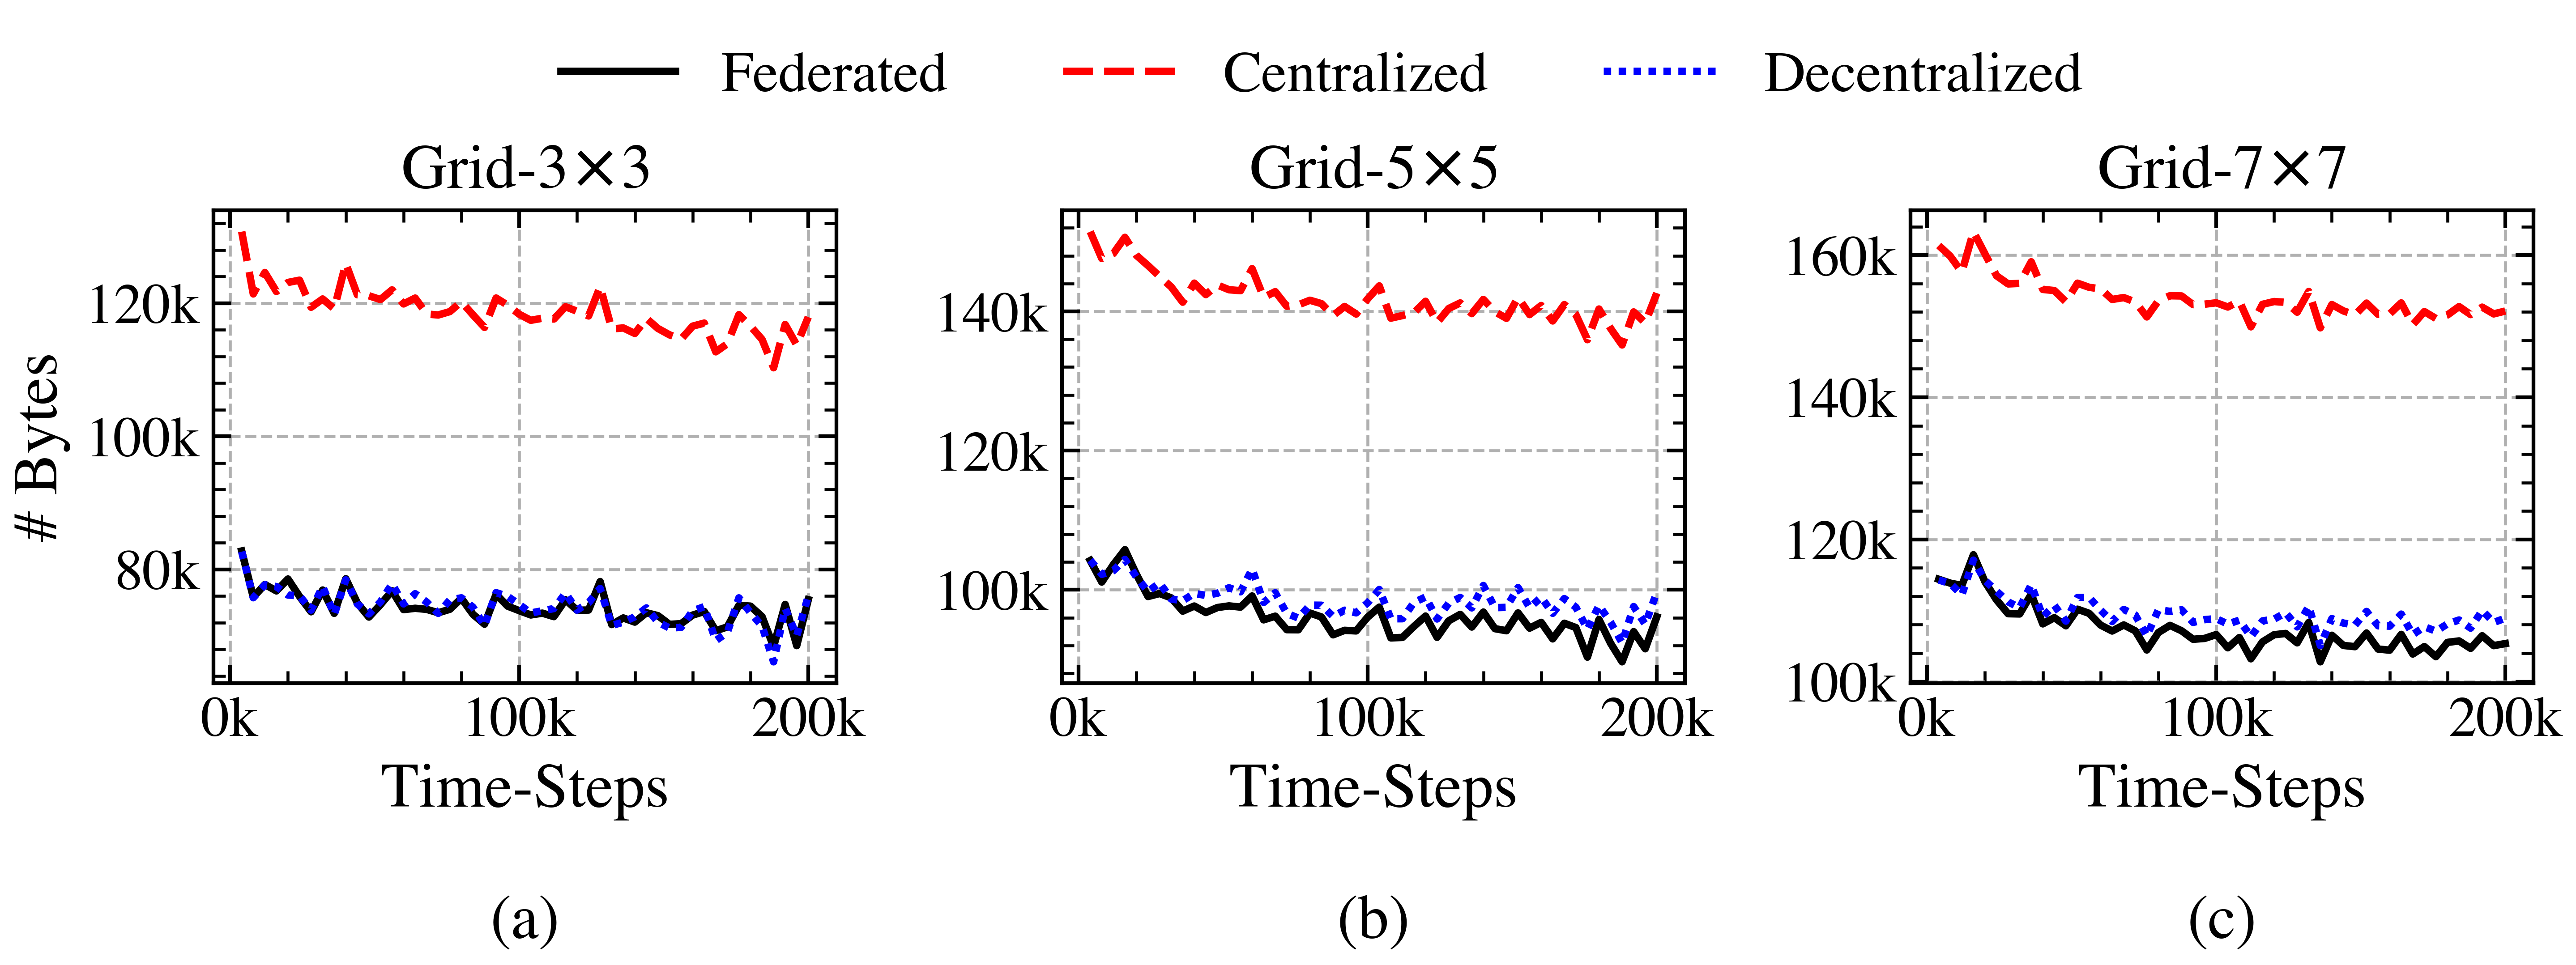

In [19]:
with sns.plotting_context("paper", font_scale=1.75):
    fig, axes = plt.subplots(ncols=len(INTERSECTIONS), figsize=(10, 4))
    for (i, intersection) in enumerate(INTERSECTIONS):
        query = f"intersection == '{intersection}' and ranked == {ranked}"
        sns.lineplot(
            data=comm_df.query(query),
            x="timesteps_total",
            y="weighted_comm_cost",
            hue="trainer",
            hue_order=HUE_ORDER,
            style="trainer",
            style_order=STYLE_ORDER,
            ci=None,
            ax=axes[i],
            linewidth=2
        )
        axes[i].grid(which="major", linestyle="--")
        title = f"\n\n{intersection}".title().replace("X", "$\\times$")
        axes[i].set_title(title)
        axes[i].set_xlabel("Time-Steps")

        # Simplify the x- and y-ticks on the individual axes.
        xlabels = ["{:,.0f}".format(x) + "k" for x in axes[i].get_xticks()/1000]
        ylabels = ["{:,.0f}".format(x) + "k" for x in axes[i].get_yticks()/1000]
        axes[i].set_xticklabels(xlabels)
        axes[i].set_yticklabels(ylabels)
        axes[i].set_ylabel("# Bytes")

        handles, labels = axes[i].get_legend_handles_labels()
        axes[i].get_legend().remove()


    for i in range(1, len(INTERSECTIONS)):
        axes[i].set_ylabel("")

    for (label, i) in zip(["a", "b", "c"], range(len(INTERSECTIONS))):
        axes[i].set_xlabel(f"Time-Steps\n\n({label})")

    handles = [copy.copy(ha) for ha in handles]
    [ha.set_linewidth(2) for ha in handles]
    fig.legend(handles, labels, frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.5125, 0.95))
    plt.tight_layout()
    plt.savefig(join(RESULTS_DIR, "weighted_total_comm_cost.pdf"))
    plt.show()

# Approximation Ratio Metrics
Here, we wish to get a sense of just *how* good the approaches are compared to one another. For this, we identify the approximation ratio of the ***Decentralized*** and ***Federated*** trainers in comparison to the ***Centralized*** trainer.

In [20]:
comm_type = "weighted_comm_cost"
comm_type = "total_comm_cost"

for trainer in ["Centralized", "Decentralized", "Federated"]:
    for intersection in [ "Grid-3x3", "Grid-5x5", "grid-7x7"]:
        q = f"trainer == '{trainer}' and intersection == '{intersection}'"

        centralized_comm_cost = comm_df.query("trainer == 'Centralized'")[comm_type].to_numpy()
        decentralized_comm_cost = comm_df.query("trainer == 'Decentralized'")[comm_type].to_numpy()
        federated_comm_cost = comm_df.query("trainer == 'Federated'")[comm_type].to_numpy()

print("Cen-Cen Ratio:", np.mean(centralized_comm_cost / centralized_comm_cost))
print("Cen-Dec Ratio:", np.mean(decentralized_comm_cost / centralized_comm_cost))
print("Cen-Fed Ratio:", np.mean(federated_comm_cost / centralized_comm_cost))

Cen-Cen Ratio: 1.0
Cen-Dec Ratio: 0.5822702382732311
Cen-Fed Ratio: 0.5675665691956034


In [21]:
reward_col = "episode_reward_mean"
comm_type = "weighted_comm_cost"

cent_comm = comm_df.query("trainer == 'Centralized'")[comm_type].to_numpy()
dec_comm = comm_df.query("trainer == 'Decentralized'")[comm_type].to_numpy()
fed_comm = comm_df.query("trainer == 'Federated'")[comm_type].to_numpy()

cent_rew = comm_df.query("trainer == 'Centralized'")[reward_col].to_numpy()
dec_rew = comm_df.query("trainer == 'Decentralized'")[reward_col].to_numpy()
fed_rew = comm_df.query("trainer == 'Federated'")[reward_col].to_numpy()

In [22]:
def percentage_change_decr(benchmark, comparator) -> float:
    benchmark_mean = benchmark.mean()
    comparator_mean = comparator.mean()
    change = benchmark - comparator
    return ((change / benchmark) * 100).mean()

def percentage_change_incr(benchmark, comparator) -> float:
    benchmark_mean = benchmark.mean()
    comparator_mean = comparator.mean()
    change = comparator - benchmark
    return ((change / benchmark) * 100).mean()

table = [
    ["Decentralized training's comm percent reduction", f"{percentage_change_decr(cent_comm, dec_comm):0.2f}%"],
    ["Federated training's comm percent reduction",     f"{percentage_change_decr(cent_comm, fed_comm):0.2f}%"],
    ["Decentralized training's ep. reward loss",        f"{percentage_change_decr(cent_rew, dec_rew):0.2f}%"],
    ["Federated training's ep. reward loss",            f"{percentage_change_decr(cent_rew, fed_rew):0.2f}%"]
]
print(tabulate.tabulate(table, tablefmt="fancy_grid"))

╒═════════════════════════════════════════════════╤════════╕
│ Decentralized training's comm percent reduction │ 34.65% │
├─────────────────────────────────────────────────┼────────┤
│ Federated training's comm percent reduction     │ 36.24% │
├─────────────────────────────────────────────────┼────────┤
│ Decentralized training's ep. reward loss        │ -8.01% │
├─────────────────────────────────────────────────┼────────┤
│ Federated training's ep. reward loss            │ -2.11% │
╘═════════════════════════════════════════════════╧════════╛


# Joint Analysis of Reward-Communication Trade-Off

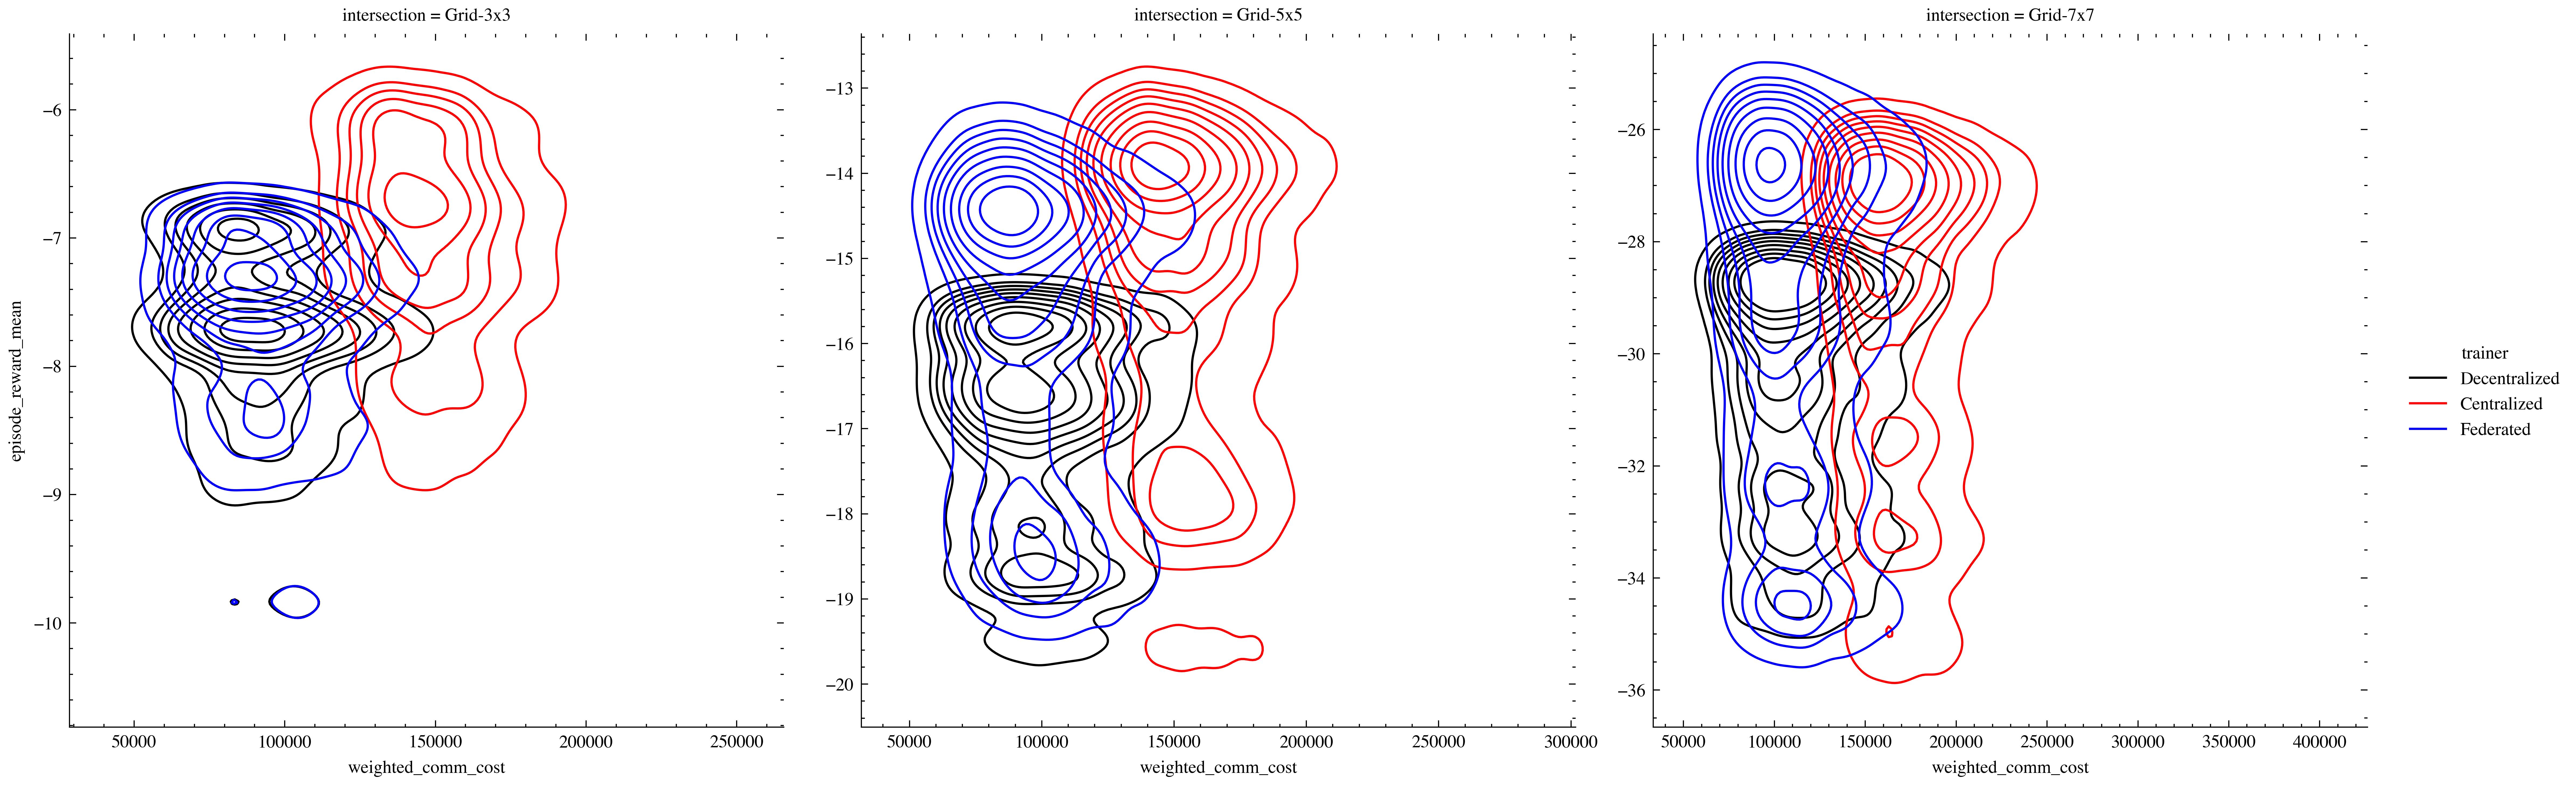

In [35]:
sns.displot(data=comm_df, kind="kde", x="weighted_comm_cost", y="episode_reward_mean", hue="trainer", col="intersection", facet_kws={"sharex": False, "sharey": False})
plt.show()